In [357]:
import pandas as pd
import numpy as np
from pymoo.core.problem import Problem
from pymoo.problems import get_problem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import pulp
import pymoo.gradient.toolbox as anp
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling

# Branch & Bound Optimization with PuLP Library

Role Reference: http://www.psypokes.com/rsefrlg/roles.php

## 0. Gather data

In [358]:
pokemon_df = pd.read_csv('data/pokemon_dataset.csv', index_col=0).reset_index(drop=True)
#pokemon_df = pokemon_df[:35]
moves_df = pd.read_csv('data/move_dataset.csv', index_col=0) # All Pokemon moves minus banned ones.
learnset_df = pd.read_csv('data/learnset_dataset.csv', index_col=0).reset_index(drop=True) # Matrix of whether Pokemon can learn move or not (only Pokemon with >=4 movesets)


moves_df = moves_df.loc[[int(i) for i in learnset_df.columns]]

roles = ["Physical Sweeper", "Special Sweeper", "Tank", "Mixed Sweeper", "Drainer", "Hybrid"]

# What each type (row) is weak against (column types).
type_effectiveness_matrix = [
    [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,],
    [1, 0.5, 2, 1, 0.5, 0.5, 1, 1, 2, 1, 1, 0.5, 2, 1, 1, 1, 0.5, 0.5,],
    [1, 0.5, 0.5, 2, 2, 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 1,],
    [1, 1, 1, 0.5, 1, 1, 1, 1, 2, 0.5, 1, 1, 1, 1, 1, 1, 0.5, 1,],
    [1, 2, 0.5, 0.5, 0.5, 2, 1, 2, 0.5, 2, 1, 2, 1, 1, 1, 1, 1, 1,],
    [1, 2, 1, 1, 1, 0.5, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1,],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0.5, 0.5, 1, 1, 0.5, 1, 2,],
    [1, 1, 1, 1, 0.5, 1, 0.5, 0.5, 2, 1, 2, 0.5, 1, 1, 1, 1, 1, 0.5,],
    [1, 1, 2, 0, 2, 2, 1, 0.5, 1, 1, 1, 1, 0.5, 1, 1, 1, 1, 1,],
    [1, 1, 1, 2, 0.5, 2, 0.5, 1, 0, 1, 1, 0.5, 2, 1, 1, 1, 1, 1,],
    [1, 1, 1, 1, 1, 1, 0.5, 1, 1, 1, 0.5, 2, 1, 2, 1, 2, 1, 1,],
    [1, 2, 1, 1, 0.5, 1, 0.5, 1, 0.5, 2, 1, 1, 2, 1, 1, 1, 1, 1,],
    [0.5, 0.5, 2, 1, 2, 1, 2, 0.5, 2, 0.5, 1, 1, 1, 1, 1, 1, 2, 1,],
    [0, 1, 1, 1, 1, 1, 0, 0.5, 1, 1, 1, 0.5, 1, 2, 1, 2, 1, 1,],
    [1, 0.5, 0.5, 0.5, 0.5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2,],
    [1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0.5, 1, 0.5, 1, 2,],
    [0.5, 2, 1, 1, 0.5, 0.5, 2, 0, 2, 0.5, 0.5, 0.5, 0.5, 1, 0.5, 1, 0.5, 0.5,],
    [1, 1, 1, 1, 1, 1, 0.5, 2, 1, 1, 1, 0.5, 1, 1, 0, 0.5, 2, 1]
]

role_weights = {
    "Physical Sweeper": {
        "HP": 0.3,  # Slight survivability
        "Attack": 1.5,  # Highest priority on raw attack power
        "SpAttack": 0.1,  # Minimal special attack importance
        "Speed": 1.2,  # High importance on speed to strike first
        "Defense": 0.4,  # Some defensive capability
        "SpDefense": 0.3  # Minimal special defense
    },
    "Special Sweeper": {
        "HP": 0.3,  # Slight survivability
        "Attack": 0.1,  # Minimal physical attack importance
        "SpAttack": 1.5,  # Highest priority on special attack power
        "Speed": 1.2,  # High importance on speed to strike first
        "Defense": 0.3,  # Minimal physical defense
        "SpDefense": 0.4  # Some special defensive capability
    },
    "Tank": {
        "HP": 1.5,  # Extreme emphasis on total health
        "Attack": 0.2,  # Minimal offensive capability
        "SpAttack": 0.2,  # Minimal special offensive capability
        "Speed": 0.3,  # Low speed priority
        "Defense": 1.2,  # High physical defense
        "SpDefense": 1.2  # High special defense
    },
    "Mixed Sweeper": {
        "HP": 0.4,  # Balanced survivability
        "Attack": 1,  # Strong physical attack
        "SpAttack": 1,  # Strong special attack
        "Speed": 1,  # Balanced speed
        "Defense": 0.3,  # Minimal physical defense
        "SpDefense": 0.3  # Minimal special defense
    },
    "Drainer": {
        "HP": 1.2,  # High health for sustained combat
        "Attack": 0.3,  # Minimal physical attack
        "SpAttack": 0.3,  # Minimal special attack
        "Speed": 0.4,  # Low speed priority
        "Defense": 1,  # Strong physical defense
        "SpDefense": 1  # Strong special defense
    },
    "Hybrid": {
        "HP": 1,
        "Attack": 1,
        "SpAttack": 1,
        "Speed": 1,
        "Defense": 1,
        "SpDefense": 1
    }
}

def compute_role_score(row, weights):
    return sum(row[stat] * weight for stat, weight in weights.items())

for role, weights in role_weights.items():
    pokemon_df[f"RoleScore_{role}"] = pokemon_df.apply(lambda row: compute_role_score(row, weights), axis=1)

role_move_preferences = {
    "Physical Sweeper": ["Earthquake", "Aerial Ace", "Rock Slide", "Brick Break", "Return", "Sludge Bomb", "Shadow Ball", "Belly Drum", "Swords Dance", "Bulk Up", "Dragon Dance"],
    "Special Sweeper": ["Thunderbolt", "Surf", "Ice Beam", "Flamethrower", "Psychic", "Dragon Claw", "Crunch", "Calm Mind", "Rain Dance", "Sunny Day"],
    "Tank": [
        "Acid Armor", "Acupressure", "Ancient Power", "Barrier", "Bulk Up", "Clangorous Soul", 
        "Clangorous Soulblaze", "Coil", "Cosmic Power", "Cotton Guard", "Curse", "Defend Order", 
        "Defense Curl", "Diamond Storm", "Extreme Evoboost", "Flower Shield", "Harden", "Iron Defense", 
        "Max Steelspike", "No Retreat", "Ominous Wind", "Order Up", "Psyshield Bash", "Shelter", 
        "Silver Wind", "Skull Bash", "Steel Wing", "Stockpile", "Stuff Cheeks", "Victory Dance", "Withdraw"
    ],
    "Mixed Sweeper": ["Earthquake", "Thunderbolt", "Surf", "Ice Beam", "Aerial Ace", "Rock Slide", "Brick Break","Swords Dance", "Calm Mind", "Dragon Dance", "Bulk Up"],
    "Drainer": [
        "Absorb", "Bitter Blade", "Bouncy Bubble", "Drain Punch", "Draining Kiss", "Dream Eater", 
        "Giga Drain", "Horn Leech", "Leech Life", "Leech Seed", "Matcha Gotcha", "Mega Drain", 
        "Oblivion Wing", "Parabolic Charge"
    ],
    "Hybrid": []
}
role_type_preferences = {
    "Tank": ["Normal", "Steel", "Fairy", "Fighting", "Ghost"],
    "Hybrid": ["Steel", "Fairy", "Fire", "Water", "Dark"],
    "Drainer": ["Grass", "Fairy", "Fighting", "Flying", "Bug"]
}
role_class_preferences = {
    "Physical Sweeper": ["Physical"],
    "Special Sweeper": ["Special"],
    "Tank": ["Physical", "Special", "Other"],
    "Mixed Sweeper": ["Physical", "Special"],
    "Drainer": ["Physical", "Special", "Other"],
    "Hybrid": ["Physical", "Special", "Other"]
}

def compute_role_move_score(move, role):
    score = 0
    for role_move in role_move_preferences[role]:
        if move["Name"].casefold() in role_move.casefold():
            score += 0.4
            break
    if move["Type"] in role_type_preferences.get(role, []):
        score += 0.3
    if move["Class"] in role_class_preferences[role]:
        score += 0.3
    
    score *= move["Power"] * (move["Accuracy"]/101)
    return score

for role in roles:
    moves_df[f"Effectiveness_{role}"] = moves_df.apply(lambda move: compute_role_move_score(move, role), axis=1)

role_move_scores = moves_df[["Name", "Effectiveness_Physical Sweeper", "Effectiveness_Special Sweeper", "Effectiveness_Tank", "Effectiveness_Mixed Sweeper", "Effectiveness_Drainer", "Effectiveness_Hybrid"]]
for role in roles:
    role_move_scores = role_move_scores.rename(columns={f"Effectiveness_{role}": role})


# Label each role column in mdata as 1 if the move is best representative of a role and 0 otherwise.
effectiveness_columns = [f"Effectiveness_{role}" for role in roles]
max_effectiveness = moves_df[effectiveness_columns].max(axis=1)
for role, col in zip(roles, effectiveness_columns):
    moves_df[role] = (moves_df[col] == max_effectiveness).astype(int)

moves_df = moves_df.drop(columns=effectiveness_columns)


types = list(pokemon_df.columns[-24:-6])

# Get resistances and weaknesses.
type_resistances = {p: {t: int(pokemon_df.loc[p, t] < 1) for t in types} for p in pokemon_df.index}
type_weaknesses = {p: {t: int(pokemon_df.loc[p, t] > 1) for t in types} for p in pokemon_df.index}

# Get which type is effective against other types.
super_effective_types = {a: {t: int(type_effectiveness_matrix[types.index(t)][types.index(moves_df.loc[a]['Type'])] > 1) for t in types} for a in moves_df.index}

# Get STAB.
stab = {p: {a: int(moves_df.loc[a, 'Type'] in [pokemon_df.loc[p, 'Type1'], pokemon_df.loc[p, 'Type2']]) for a in moves_df.index} for p in pokemon_df.index}

indexes = [] # Prepare Y.
pokemon_moves = {} # Prepare hmap for quick reference of moves each Pokemon (index) can learn.
for p in pokemon_df.index:
    pokemon_moves[p] = [int(a) for a in learnset_df.loc[p][learnset_df.loc[p]==1].index]
    indexes += [(p, int(a)) for a in learnset_df.loc[p][learnset_df.loc[p]==1].index]


# Prepare design variable R.
R_list = [(p, s) for p in pokemon_df.index for s in roles]


In [359]:
a = 0
for z in pokemon_moves.values():
    a= max(a, len(z))
a

82

## 4. Setup Optimization Problem

In [407]:
class Pokemon(Problem):

    def __init__(self, pokemon_df, pokemon_moves, roles, stab, role_move_scores, super_effective_types, type_resistances, type_weaknesses, weight):
        # Set problem parameters
        num_pokemon = len(pokemon_df)
        num_moves = sum(len(moves) for moves in pokemon_moves.values()) #per pokemon
        self.max_moves = 90
        num_roles = len(roles)
        
        n_var = num_pokemon + self.max_moves*num_pokemon + num_pokemon * num_roles # + num_roles * num_moves  # Decision variables

        super().__init__(n_var=n_var, n_obj=2, n_ieq_constr=2, n_eq_constr=3, xl=0, xu=1, vtype=bool)

        # Problem-specific data
        self.pokemon_df = pokemon_df
        self.pokemon_moves = pokemon_moves
        self.roles = roles
        self.stab = stab
        self.role_move_scores = role_move_scores
        self.super_effective_types = super_effective_types
        self.type_resistances = type_resistances
        self.type_weaknesses = type_weaknesses
        self.weight = weight

        self.num_pokemon = num_pokemon
        self.num_moves = num_moves
        self.num_roles = num_roles

    def _evaluate(self, x, out, *args, **kwargs):
        # Split decision vector `x` into variables
        N = self.num_pokemon
        M = self.num_pokemon*self.max_moves
        J = self.num_roles
        Z = self.max_moves
        X = x[:,:N]  # Pokémon selection variables
        Y = x[:,N:N+M]  # Move selection variables
        R = x[:,N+M:N+M+N*J]  # Role assignment variables
        #L = x[:,N+M+N*J:]  # Any other variables

        for p in self.pokemon_df.index:
            Y[:, p*Z:(p+1)*Z] *= X[:, p][:, None]
            R[:, p*J:(p+1)*J] *= X[:, p][:, None]

        for p, v in self.pokemon_moves.items():
            #Zero out moves outside the range
            Y[:, p*Z+len(v):(p+1)*Z] = 0
            
        obj1 = -sum(R[:,p*J+r] * self.pokemon_df.loc[p, f"RoleScore_{role}"] for r, role in enumerate(self.roles) for p in self.pokemon_df.index) # Maximize team stats
        obj2 = 0
        for p in self.pokemon_df.index:
            for r in self.roles:
                for i, a in enumerate(self.pokemon_moves[p]):
                    obj2 += (1 + (0.5 * self.stab[p][a])) * self.role_move_scores.loc[a, r] * Y[:, p*Z+i]

        obj2 = -obj2
        out["F"] = np.column_stack([self.weight*obj1, (1-self.weight)*obj2])
        h1 = np.sum(X, axis=1) - 6
        h2 = np.sum(Y, axis=1) - 24
        h3 = np.sum(R, axis=1) - 6
        g1 = np.zeros(len(Y))
        # max 24 moves, 4 moves per pokemon
        for p, v in self.pokemon_moves.items():
            const = np.sum(Y[:, p*Z:(p+1)*Z], axis=1) - 4*X[:, p]
            g1+= const
            
        g2 = np.zeros(len(R))
        #max 1 role per pokemon
        for p in self.pokemon_df.index:
            const = np.sum(R[:, p*J:(p+1)*J], axis=1) - 1*X[:, p]
            g2+=const
        

        out["H"] = np.column_stack([h1, h2, h3])
        out["G"] = np.column_stack([g1, g2])




In [408]:
from pymoo.core.sampling import Sampling

class CustomBinarySampling(Sampling):
    def __init__(self,  pokemon_df, pokemon_moves, roles):
        super().__init__()
        self.num_pokemon = len(pokemon_df)
        self.num_moves = sum(len(moves) for moves in pokemon_moves.values())
        self.max_moves = 90
        self.num_roles = len(roles)
        self.pokemon_moves = pokemon_moves
        
    def _do(self, problem, n_samples, **kwargs):
        # Create initial population
        x = np.random.random((n_samples, problem.n_var)) < 0.05 # Initial binary sampling
        N = self.num_pokemon
        M = self.num_pokemon*self.max_moves
        J = self.num_roles
        Z = self.max_moves

        # Ensure consistency in the sampling

        for p in range(N):
            pokemon_mask = x[:, p] == 0
            
            # Zero out roles for unselected pokemon
            x[pokemon_mask, N + M + p*J : N + M + (p+1)*J] = 0       
            x[pokemon_mask, N+p*Z:N+(p+1)*Z] = 0

        for p, v in self.pokemon_moves.items():
            #Zero out moves outside the range
            x[:, N+p*Z+len(v):N+(p+1)*Z] = 0

        
        return x

In [406]:
problem = Pokemon(
    pokemon_df=pokemon_df,
    pokemon_moves=pokemon_moves,
    roles=roles,
    stab=stab,
    role_move_scores=role_move_scores,
    super_effective_types=super_effective_types,
    type_resistances=type_resistances,
    type_weaknesses=type_weaknesses
)

algorithm = NSGA2(pop_size=180,
                  sampling=CustomBinarySampling(pokemon_df, pokemon_moves, roles),
                  crossover=TwoPointCrossover(),
                  mutation=BitflipMutation(),
                  eliminate_duplicates=True
)


res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

print("Best solution: \nX = %s\nF = %s" % (res.X, res.F))

TypeError: Pokemon.__init__() missing 1 required positional argument: 'weight'

In [409]:

final = []
for a in np.arange(0.1, 1.1, 0.1):
    problem = Pokemon(
        pokemon_df=pokemon_df,
        pokemon_moves=pokemon_moves,
        roles=roles,
        stab=stab,
        role_move_scores=role_move_scores,
        super_effective_types=super_effective_types,
        type_resistances=type_resistances,
        type_weaknesses=type_weaknesses,
        weight=a
    )

    algorithm = NSGA2(pop_size=180,
                    sampling=CustomBinarySampling(pokemon_df, pokemon_moves, roles),
                    crossover=TwoPointCrossover(),
                    mutation=BitflipMutation(),
                    eliminate_duplicates=True
    )


    res = minimize(problem,
                algorithm,
                ('n_gen', 100),
                seed=1,
                verbose=True)

    print("Best solution: \nX = %s\nF = %s" % (res.X, res.F))
    final.append([res.F[0]])

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      180 |      1 |  5.9997000000 |  2.075527E+01 |             - |             -
     2 |      360 |      1 |  5.9997000000 |  1.311638E+01 |             - |             -
     3 |      540 |      1 |  5.9997000000 |  1.132749E+01 |             - |             -
     4 |      720 |      1 |  5.9997000000 |  1.006639E+01 |             - |             -
     5 |      900 |      1 |  4.9998000000 |  9.2330666667 |             - |             -
     6 |     1080 |      1 |  4.9998000000 |  8.6941727778 |             - |             -
     7 |     1260 |      1 |  4.9998000000 |  8.0275127778 |             - |             -
     8 |     1440 |      1 |  4.9998000000 |  7.4664083333 |             - |             -
     9 |     1620 |      1 |  4.9997000000 |  7.0664105556 |             - |             -
    10 |     1800 |      1 |  4.9997000000 |  6.5553200000 |             - |             -

In [415]:
final1 = []
for f in final:
    c = f[0]
    final1.append([c[0], c[1]])

final1

[[np.float64(-224.06), np.float64(-3244.8029702970293)],
 [np.float64(-448.12), np.float64(-2884.269306930693)],
 [np.float64(-672.1800000000001), np.float64(-2523.735643564356)],
 [np.float64(-896.24), np.float64(-2163.2019801980196)],
 [np.float64(-1120.3), np.float64(-1802.668316831683)],
 [np.float64(-1344.36), np.float64(-1442.1346534653464)],
 [np.float64(-1568.42), np.float64(-1081.6009900990096)],
 [np.float64(-1792.48), np.float64(-721.067326732673)],
 [np.float64(-2016.54), np.float64(-360.5336633663365)],
 [np.float64(-2240.6), np.float64(-0.0)]]

In [416]:
import pandas as pd 
df = pd.DataFrame(final1)
df.to_csv("final.csv")

In [378]:
chosen = np.asarray(res.X[0][0:301]==1).nonzero()[0]
chosen

array([ 43,  99, 133, 142, 173, 213])

In [379]:
moves = np.asarray(res.X[0][301:301+90*301] == 1).nonzero()[0]
roles1 = np.asarray(res.X[0][301+90*301:]==1).nonzero()[0]
# Print moves range for each chosen Pokémon
for p in range(301):
    if p in chosen:
        move_range = moves[(moves >= p*90) & (moves < (p+1)*90)]  # Filter moves in range
        print(f"Pokemon {p} Move Range: {p*90} - {(p+1)*90}")
        print(f"Moves: {move_range}")  # Normalize to move indices within the range

print("role range")
for p in range(301):
    if p in chosen:
        roles_range = roles1[(roles1 >= p*6) & (roles1 < (p+1)*6)]
        print(f"Pokemon {p} Role Range: {p*6} - {(p+1)*6}")
        print(f"Roles: {roles_range}")

Pokemon 43 Move Range: 3870 - 3960
Moves: [3873 3879 3884 3894 3905]
Pokemon 99 Move Range: 8910 - 9000
Moves: [8924 8934 8939]
Pokemon 133 Move Range: 11970 - 12060
Moves: [11970 11998 11999 12002 12024 12036 12039 12049 12050]
Pokemon 142 Move Range: 12780 - 12870
Moves: [12780 12804 12814 12823 12826 12830 12833]
Pokemon 173 Move Range: 15570 - 15660
Moves: []
Pokemon 213 Move Range: 19170 - 19260
Moves: []
role range
Pokemon 43 Role Range: 258 - 264
Roles: [258 259]
Pokemon 99 Role Range: 594 - 600
Roles: [598]
Pokemon 133 Role Range: 798 - 804
Roles: []
Pokemon 142 Role Range: 852 - 858
Roles: [856]
Pokemon 173 Role Range: 1038 - 1044
Roles: [1041 1043]
Pokemon 213 Role Range: 1278 - 1284
Roles: []


In [380]:
np.asarray(res.X[0][301:301+90*301]==1).nonzero()[0]

array([   34,   143,   336,   682,  1983,  2006,  2465,  3138,  3812,
        3873,  3879,  3884,  3894,  3905,  4045,  4188,  4975,  5414,
        5913,  7036,  7081,  7839,  7895,  8054,  8159,  8924,  8934,
        8939,  9285, 10227, 10242, 10246, 11358, 11612, 11970, 11998,
       11999, 12002, 12024, 12036, 12039, 12049, 12050, 12345, 12456,
       12620, 12780, 12804, 12814, 12823, 12826, 12830, 12833, 13120,
       14598, 14783, 14823, 15325, 15330, 15501, 15688, 16050, 16124,
       16986, 17116, 17117, 17125, 17142, 17338, 18708, 18932, 19825,
       19991, 20523, 20536, 20634, 20909, 21114, 21432, 21442, 21505,
       21745, 22064, 22221, 22434, 22640, 23333, 23886, 24509, 24662,
       25240, 25479, 25482, 25497, 26236, 26649, 27042])

In [381]:
np.asarray(res.X[0][301:301+90*301]==1).nonzero()[0].shape

(97,)

In [382]:
np.asarray(res.X[0][301+90*301:]==1).nonzero()

(array([ 258,  259,  598,  856, 1041, 1043, 1392, 1441, 1789]),)

In [383]:
pokemon_df[pokemon_df.index.isin(chosen)]


,Name,Number,Alt Number,HP,Attack,SpAttack,Defense,SpDefense,Speed,Legendary,...,Dragon,Dark,Steel,Fairy,RoleScore_Physical Sweeper,RoleScore_Special Sweeper,RoleScore_Tank,RoleScore_Mixed Sweeper,RoleScore_Drainer,RoleScore_Hybrid
43,Starmie,121,NaN,60,75,100,85,85,115,0,...,1.0,2.0,0.5,1.0,338.0,373.0,363.5,365.0,340.5,520
99,Wailord,321,NaN,170,90,90,45,45,60,0,...,1.0,1.0,0.5,1.0,298.5,298.5,417.0,335.0,372.0,500
133,Rhyperior,464,NaN,115,140,55,130,55,40,0,...,1.0,1.0,2.0,1.0,366.5,240.0,445.5,336.5,397.5,535
142,Gallade,475,NaN,68,125,65,65,115,80,0,...,1.0,1.0,1.0,2.0,370.9,291.9,380.0,351.2,350.6,518
173,Carracosta,565,NaN,74,108,83,133,65,32,0,...,1.0,1.0,1.0,1.0,303.6,261.8,396.4,312.0,356.9,495
213,Barbaracle,689,NaN,72,105,54,115,86,68,0,...,1.0,1.0,1.0,1.0,337.9,263.6,401.4,316.1,362.3,500


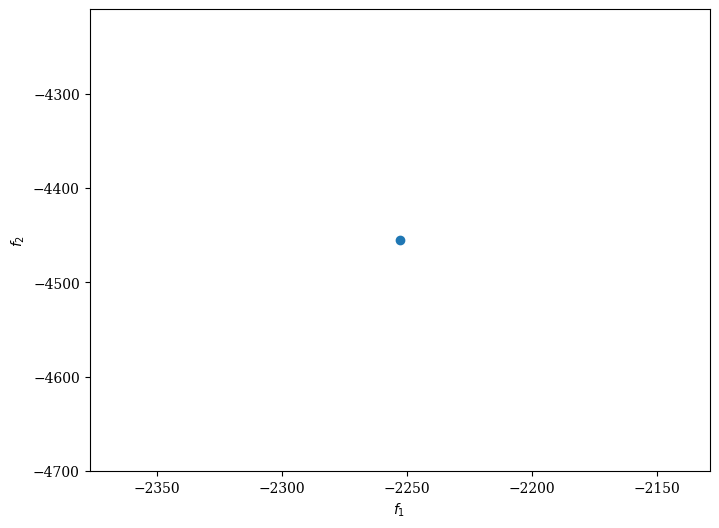

In [256]:
Scatter().add(res.F).show()